# 12 Word World

In [1]:
# Python dependencies
import warnings
import random

# 3rd Party dependencies
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import MaxNLocator

In [2]:
torch.manual_seed(123)
warnings.filterwarnings('ignore')

## Intentionally Limited Vocabulary

We'll train a model with a text that's limited to this vocabulary.

In [3]:
adjectives = ["Serene", "Vibrant", "Silent", "Endless"]
nouns = ["river", "dream", "mountain", "idea"]
verbs = ["flows", "grows", "whispers", "shines"]

We generate random sentences with those words by randomly concatenating a noun, an adjective and a verb.

In [4]:
sentence_count = 100

twelve_word_world = [
    random.choice(adjectives) + " " + random.choice(nouns) + " " + random.choice(verbs)
    for _ in range(sentence_count)
]

In [5]:
from scratch.tokenizers.preprocessor import Preprocessor
from scratch.tokenizers.simple_tokenizer import SimpleTokenizer

def strings_to_text(strings: list[str]):
    return ".<|endoftext|> ".join(strings) + ".<|endoftext|>"

text_data = strings_to_text(twelve_word_world)

text_data

'Vibrant dream flows.<|endoftext|> Endless river whispers.<|endoftext|> Vibrant mountain whispers.<|endoftext|> Silent dream grows.<|endoftext|> Serene dream grows.<|endoftext|> Serene idea whispers.<|endoftext|> Serene dream whispers.<|endoftext|> Endless dream grows.<|endoftext|> Endless dream flows.<|endoftext|> Vibrant mountain grows.<|endoftext|> Endless river shines.<|endoftext|> Vibrant river grows.<|endoftext|> Vibrant mountain shines.<|endoftext|> Vibrant idea grows.<|endoftext|> Endless river shines.<|endoftext|> Serene dream shines.<|endoftext|> Vibrant idea grows.<|endoftext|> Vibrant idea flows.<|endoftext|> Silent river grows.<|endoftext|> Serene dream grows.<|endoftext|> Vibrant mountain whispers.<|endoftext|> Endless idea grows.<|endoftext|> Endless idea whispers.<|endoftext|> Endless idea flows.<|endoftext|> Serene mountain shines.<|endoftext|> Silent dream grows.<|endoftext|> Silent mountain flows.<|endoftext|> Silent mountain whispers.<|endoftext|> Endless mountain w

In [6]:
all_tokens = adjectives + nouns + verbs + [".", "<|endoftext|>", "<|unk|>"]
random.shuffle(all_tokens)

randomized_tokens = " ".join(all_tokens)

In [26]:
preprocessor = Preprocessor()
source = preprocessor.preprocess(randomized_tokens)
tokenizer = SimpleTokenizer(source)

print("Vocabulary size", len(tokenizer.str_to_int))
print("Sentences", len(twelve_word_world))
print("Total characters", len(text_data))
print("Total tokens", len(tokenizer.encode(text_data)))

Vocabulary size 15
Sentences 100
Total characters 3510
Total tokens 500


In [27]:
tokenizer.int_to_str

{0: '.',
 1: '<|endoftext|>',
 2: '<|unk|>',
 3: 'Endless',
 4: 'Serene',
 5: 'Silent',
 6: 'Vibrant',
 7: 'dream',
 8: 'flows',
 9: 'grows',
 10: 'idea',
 11: 'mountain',
 12: 'river',
 13: 'shines',
 14: 'whispers'}

## Micro GPT Model

We instantiate a very tiny model in order to make it quite easy to debug.

In [8]:
from scratch.gpt_config import GptConfig
from scratch.gpt_model import GptModel

config = GptConfig(
    vocab_size = len(tokenizer.str_to_int),
    context_length = 5,
    embedding_dimension = 4,
    head_count = 2,
    layer_count = 2,
    drop_rate = .1,
    qkv_bias = False
)

model = GptModel(config)

Now that our model has just been created with random weights, we'll store its embedding weights so that we can later compare the initial values with the trained ones.

In [9]:
initial_embeddings = model.token_embeddings.weight

### Preparing the Training and Validation Datasets

In [10]:
train_ratio = 0.9
split_idx = int(train_ratio * len(twelve_word_world))

train_data = strings_to_text(twelve_word_world[:split_idx])
validation_data = strings_to_text(twelve_word_world[split_idx:])

print(validation_data)

Vibrant idea shines.<|endoftext|> Serene river grows.<|endoftext|> Endless dream flows.<|endoftext|> Serene river flows.<|endoftext|> Silent river shines.<|endoftext|> Serene dream flows.<|endoftext|> Serene mountain shines.<|endoftext|> Endless idea flows.<|endoftext|> Silent river flows.<|endoftext|> Vibrant idea shines.<|endoftext|>


In [11]:
from scratch.dataloader import create_dataloader

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0,
    tokenizer=tokenizer,
)

validation_loader = create_dataloader(
    validation_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0,
    tokenizer=tokenizer,
)

### Checking the Losses before Training

In [12]:
from scratch.training.loader_loss import LoaderLoss

loader_loss = LoaderLoss(model)

with torch.no_grad():
    train_loss = loader_loss.calc(train_loader)
    validation_loss = loader_loss.calc(validation_loader)

print("Training loss", train_loss)
print("Validation loss", validation_loss)

Training loss 2.7097890160300513
Validation loss 2.8890981674194336


## Train

### Prepare a Trainer

In [13]:
from scratch.generators.probabilistic_text_generator import ProbabilisticTextGenerator
from scratch.training.simple_trainer import SimpleTrainer

generator = ProbabilisticTextGenerator(
    model,
    config.context_length,
    temperature = 1.1,
    top_k = 4,
    eos_id = tokenizer.encode("<|endoftext|>")[0]
)

trainer = SimpleTrainer(
    model,
    train_loader,
    validation_loader,
    tokenizer = tokenizer,
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr = 0.05,
        weight_decay = 0.1
    ),
    generator = generator
)

### Run the Training Loop

In [14]:
num_epochs = 5

train_losses, validation_losses, tokens_seen = trainer.train(
    num_epochs = num_epochs,
    eval_freq = 50,
    eval_iter = 10**10,
    start_context = "Silent mountain")


- Step 0
- Train loss 2.6067253676327793
- Evaluation loss 2.731452751159668
- Generated: Silent mountain whispers.. Silent Vibrant

- Step 50
- Train loss 1.0112934356386012
- Evaluation loss 1.1179678559303283
- Generated: Silent mountain whispers.

- Step 100
- Train loss 0.9054090922529047
- Evaluation loss 0.9763160586357117
- Generated: Silent mountain whispers.

- Step 150
- Train loss 0.8880873159928755
- Evaluation loss 0.9422512531280518
- Generated: Silent mountain shines.

- Step 200
- Train loss 0.8743109824982557
- Evaluation loss 0.9359467148780822
- Generated: Silent mountain flows.

Training finished


### Checking the Losses during Training

In [15]:
def plot_losses(epochs_seen, tokens_seen, train_looses, validation_looses):
    fig, ax1 = plt.subplots(figsize=(5,3))

    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    ax1.plot(epochs_seen, train_looses, label="Training loss")
    ax1.plot(epochs_seen, validation_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

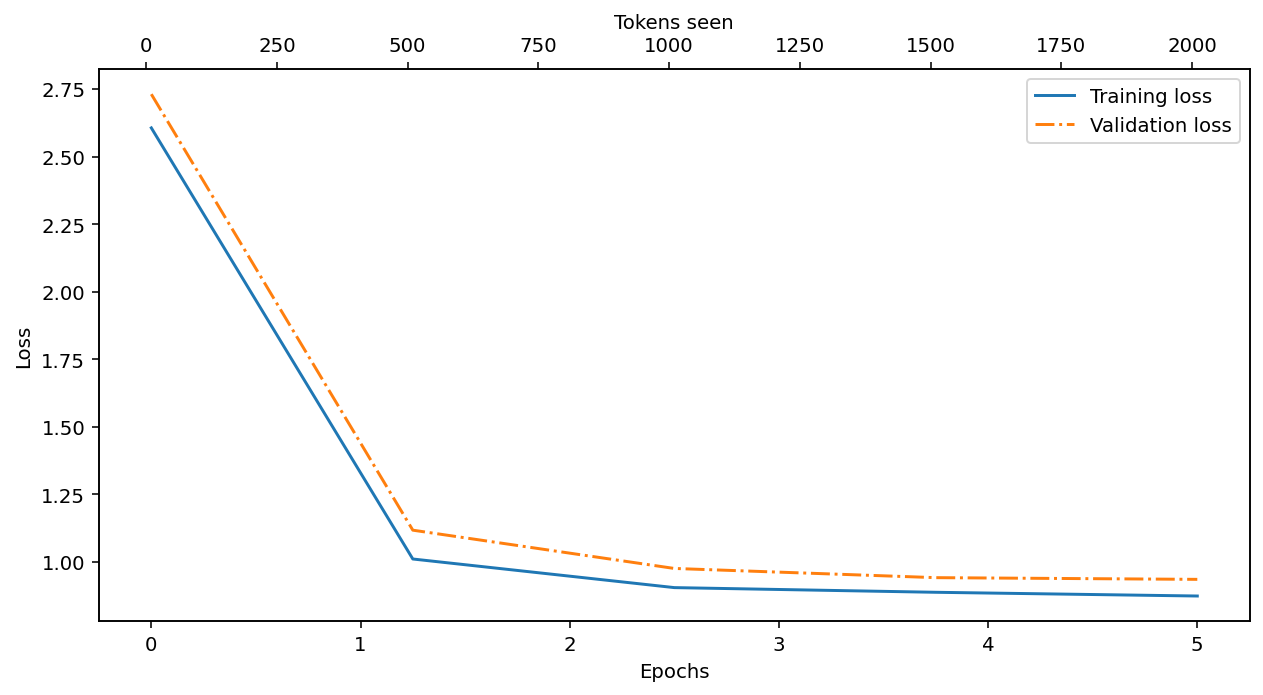

In [16]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, validation_losses)

## Checking the Embedding Changes

In [17]:
initial_embeddings

Parameter containing:
tensor([[ 1.3782,  0.7549, -0.5699, -0.9932],
        [ 0.2800,  0.3895, -1.3823,  0.2877],
        [ 0.2546, -0.3959,  0.2318, -0.4680],
        [ 0.5638, -0.3844,  0.0446,  0.5890],
        [ 0.3591, -0.7075, -0.1917,  1.4551],
        [ 0.2610, -0.5851,  0.0297,  0.7400],
        [ 0.3055, -0.8183,  0.0811,  0.2644],
        [-1.2025,  0.4456,  0.5175, -0.1829],
        [ 0.4032,  0.1246,  0.0402, -0.3069],
        [-0.1277, -0.4136,  0.4305, -0.3739],
        [-0.4563,  0.7950,  0.2477, -0.4296],
        [-0.2523,  0.6317,  0.2362, -0.1140],
        [-1.0426,  0.4860, -0.0628, -0.4832],
        [-0.3670, -0.7727,  1.2497, -1.1500],
        [-0.0214, -0.4165,  0.4080, -0.3795]], device='cuda:0',
       requires_grad=True)

In [18]:
trained_embeddings = model.token_embeddings.weight

trained_embeddings

Parameter containing:
tensor([[ 1.3782,  0.7549, -0.5699, -0.9932],
        [ 0.2800,  0.3895, -1.3823,  0.2877],
        [ 0.2546, -0.3959,  0.2318, -0.4680],
        [ 0.5638, -0.3844,  0.0446,  0.5890],
        [ 0.3591, -0.7075, -0.1917,  1.4551],
        [ 0.2610, -0.5851,  0.0297,  0.7400],
        [ 0.3055, -0.8183,  0.0811,  0.2644],
        [-1.2025,  0.4456,  0.5175, -0.1829],
        [ 0.4032,  0.1246,  0.0402, -0.3069],
        [-0.1277, -0.4136,  0.4305, -0.3739],
        [-0.4563,  0.7950,  0.2477, -0.4296],
        [-0.2523,  0.6317,  0.2362, -0.1140],
        [-1.0426,  0.4860, -0.0628, -0.4832],
        [-0.3670, -0.7727,  1.2497, -1.1500],
        [-0.0214, -0.4165,  0.4080, -0.3795]], device='cuda:0',
       requires_grad=True)

In [24]:
def classify(word: str) -> int:
    if word in adjectives:
        return 0
    if word in nouns:
        return 1
    if word in verbs:
        return 2
    return 3

classes = {
    0: "Adjective",
    1: "Noun",
    2: "Verb",
    3: "Keyword",
}

classification = {token: classify(word) for token, word in tokenizer.int_to_str.items()}
classification

{0: 3,
 1: 3,
 2: 3,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 1,
 8: 2,
 9: 2,
 10: 1,
 11: 1,
 12: 1,
 13: 2,
 14: 2}

In [20]:
colors = {
    0: "tab:blue",
    1: "tab:green",
    2: "tab:red",
    3: "tab:purple",
}

In [21]:
def plot_embeddings(embeddings: torch.tensor, title: str):
    fig, ax = plt.subplots()
    reducer = umap.UMAP(n_components = 2)
    reduced_embeddings = reducer.fit_transform(embeddings.tolist())
    groups = np.array(list(classification.values()))
    for group in np.unique(groups):
        index = np.where(groups == group)
        ax.scatter(
            reduced_embeddings[index][:, 0],
            reduced_embeddings[index][:, 1],
            c = colors[group],
            label = classes[group]
        )
    ax.legend()
    plt.title(title)
    plt.show()

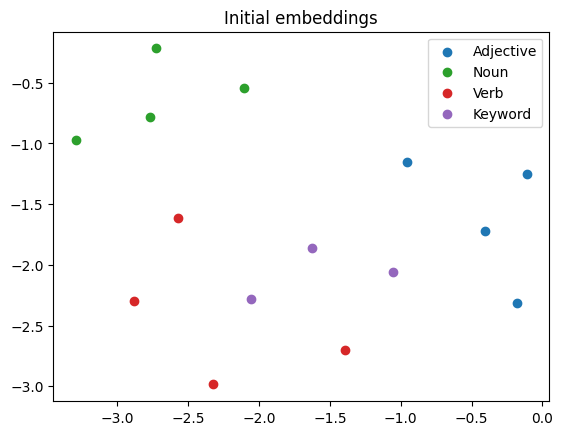

In [22]:
plot_embeddings(initial_embeddings, "Initial embeddings")

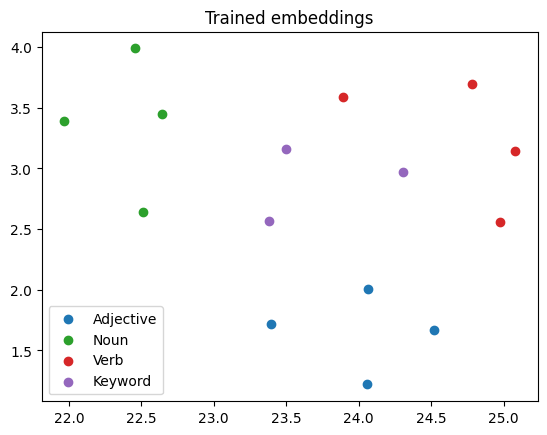

In [23]:
plot_embeddings(trained_embeddings, "Trained embeddings")